# Coding Problem

In [1]:
# https://drive.google.com/file/d/1LE9ELZNOh9_LQxNt5ExjnITFwPUZ3n_Q/view?usp=sharing
system("gdown --id 1LE9ELZNOh9_LQxNt5ExjnITFwPUZ3n_Q")
lambda = read.delim("lambda.txt", header=FALSE)
lambda = as.data.frame(lambda)

# https://drive.google.com/file/d/14w6xx-JQsKVY38iuUX1a-Kkm3z0bjlMC/view?usp=sharing
system("gdown --id 14w6xx-JQsKVY38iuUX1a-Kkm3z0bjlMC")
train = read.delim("train.txt")
data = as.data.frame(train)

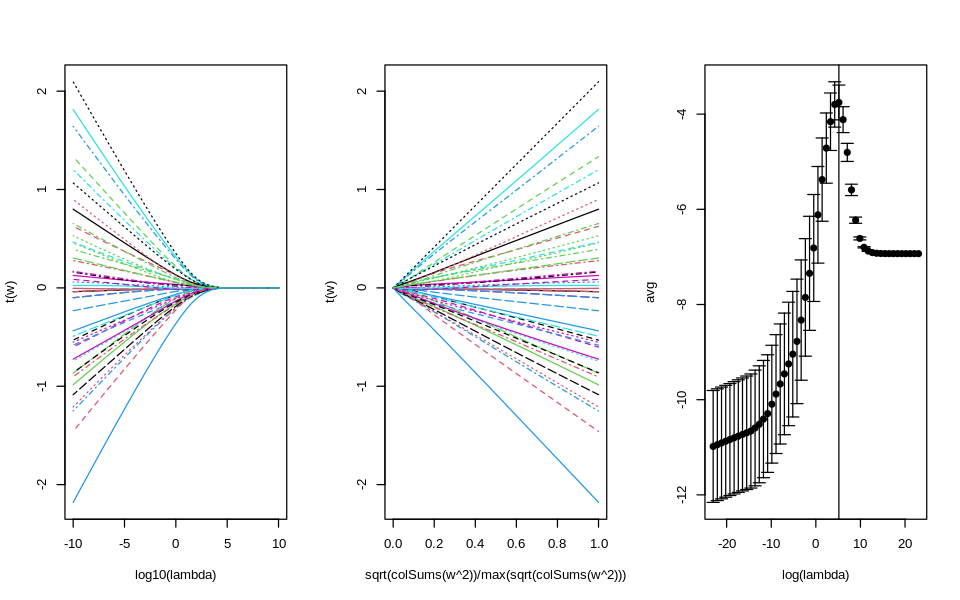

In [2]:
mylogistic2 <- function(y,x,method="Hessian",lambda=0,w_old=NULL){
  maxIter = 25
  n = dim(x)[1]
  p = dim(x)[2]
  
  x = cbind(matrix(1,n,1),x)
  XtX = t(x)%*%x
  
  if (is.null(w_old)){
      w_old = matrix(0,p+1,1)
  }
  prob = 1/(1+exp(-x%*%w_old))
  
  for (iter in 1:maxIter){
    if (method == "Hessian"){
      R = prob*(1-prob)
      temp = matrix(rep(sqrt(R),p+1),n,p+1)*x
      XRX = t(temp)%*% temp
      l2 <- matrix(0, p+1, p+1)
      diag(l2) <- 2*lambda
      # Newton-Raphson update
      invH = solve(XRX + l2)
      w = w_old + invH%*%(t(x)%*%(y-prob) - 2*lambda*w_old) 
    }
    else{
      # This is a method using the upper bound of Hessian
      # Because prob*(1-prob) <= 0.25
      # We replace prob*(1-prob) by 0.25
      z =  0.25*x%*%w_old + (y-prob);
      w = solve(0.25*XtX)%*%(t(x)%*%z);
    }
    if (max(abs(w_old-w))/sqrt(sum(w^2)) < 1e-6){
      break
    }
    prob = 1/(1+exp(-x%*%w))
    # prob[prob>0.999] = 0.999
    # prob[prob<0.001] = 0.001
    
    w_old = w
  }
  
  se = sqrt(diag(invH))
  return(list(prob=prob,w=w,se=se,Iter = iter)) 
}

w <- matrix(0, 46, nrow(lambda))
w_old = NULL
for(i in 1:nrow(lambda)) {
    my.fit<- mylogistic2(y=as.numeric(data$y),x=as.matrix(data[,2:46]),method="Hessian",lambda=lambda[i,],w_old=w_old)
    w[,i] = my.fit$w
    w_old = my.fit$w
}

options(repr.plot.width=8, repr.plot.height=5)
par(mfrow=c(1,3))
matplot(x=log10(lambda), y=t(w), type='l')
matplot(x=sqrt(colSums(w^2))/max(sqrt(colSums(w^2))), y=t(w), type='l')

nfolds <- 10
n <- nrow(data)

set.seed(200)
dat_idx <- sample(1:n,n,replace = F)
cv_err <- matrix(0,nfolds,nrow(lambda))
for(i in 1:nfolds){
    idx_test <- dat_idx[((i-1)*n/nfolds+1):(i*n/nfolds)]
    w_old = NULL

    for (j in 1:nrow(lambda)){
        my.fit<- mylogistic2(y=as.numeric(data$y[-idx_test]),x=as.matrix(data[-idx_test,2:46]),method="Hessian",lambda=lambda[j,],w_old=w_old)
        w_old = my.fit$w
        w = my.fit$w
        x = as.matrix(data[idx_test,2:46])
        x = cbind(matrix(1,length(idx_test),1),x)
        pred = 1/(1+exp(-x%*%w))
        pred[pred>0.999] = 0.999
        pred[pred<0.001] = 0.001
        y = data$y[idx_test]
        cv_err[i,j] <- sum(y*log(pred)+(1-y)*log(1-pred))
    }
}

sd = apply(cv_err, 2, sd)/sqrt(10)
avg = colMeans(cv_err)
matplot(x=log(lambda), y=avg, ylim=range(c(avg-sd, avg+sd)), pch=19)
abline(v=log(lambda)[which.max(avg),])
options(warn=-1)
arrows(log(lambda)[,], avg-sd, log(lambda)[,], avg+sd, length=0.05, angle=90, code=3)